In [ ]:
from __future__ import annotations
import os
os.chdir('/home/elopez/RL-Project/DKONG')
import socket
HOSTNAME = socket.gethostname()

if HOSTNAME == "cudahpc16":
	# idk who set up this cluster but without this the gpu is not detected
	os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
	os.environ["CUDA_VISIBLE_DEVICES"] = "6"
	os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import argparse
import random
from collections import deque
from pathlib import Path
from typing import Deque, Dict, List, Callable

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

from environment.env import make_env
from models.base import CustomCNN
from _logging import load_config, load_pretrain_config

In [2]:
main_config = load_config()
pretrain_config = load_pretrain_config()
pre_cfg = pretrain_config["pretrain"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

random_seed = pre_cfg.get("seed")
if random_seed is not None:
	random.seed(random_seed)
	np.random.seed(random_seed)
	torch.manual_seed(random_seed)

Using device: cuda


In [3]:
env = make_env(main_config)
frame_stack = int(main_config["env"]["frame_stack"])
# print info about env
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Observation space: Box(0.0, 1.0, (1, 128, 128), float32)
Action space: Discrete(9)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [4]:
def create_stacked_space(
	observation_space: gym.spaces.Box,
	frame_stack: int,
) -> gym.spaces.Box:
	# Create a space like (frame_stack * C, H, W)
	c, h, w = observation_space.shape
	stacked_shape = (frame_stack * c, h, w)
	low = np.repeat(observation_space.low, frame_stack, axis=0)
	high = np.repeat(observation_space.high, frame_stack, axis=0)
	return gym.spaces.Box(low=low, high=high, dtype=observation_space.dtype, shape=stacked_shape)

stacked_space = create_stacked_space(env.observation_space, frame_stack)
print(f"Stacked space: {stacked_space}")

Stacked space: Box(0.0, 1.0, (4, 128, 128), float32)


In [5]:
features_kwargs = (
	main_config["model"]["PPO"]["policy_kwargs"].get("features_extractor_kwargs", {})
)
features_dim = int(features_kwargs.get("features_dim", 256))
extractor = CustomCNN(stacked_space, features_dim=features_dim).to(device)
print(f"Extractor: {extractor}")

Extractor: CustomCNN(
  (cnn): Sequential(
    (0): Conv2d(4, 64, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=25088, out_features=256, bias=True)
    (1): ReLU()
  )
)


In [6]:
class InverseDynamicsHead(nn.Module):
	def __init__(self, input_dim: int, hidden_dim: int, n_actions: int):
		super().__init__()
		self.net = nn.Sequential(
			nn.Linear(input_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, n_actions),
		)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.net(x)

head_hidden_dim = int(pre_cfg.get("head_hidden_dim", 512))
n_actions = env.action_space.n
head = InverseDynamicsHead(features_dim * 2, head_hidden_dim, n_actions).to(device)
print(f"Head: {head}")

Head: InverseDynamicsHead(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=9, bias=True)
  )
)


In [7]:
optimizer = optim.Adam(
	list(extractor.parameters()) + list(head.parameters()),
	lr=float(pre_cfg["learning_rate"]),
)
criterion = nn.CrossEntropyLoss()

total_steps = int(pre_cfg["total_steps"])
save_every = int(pre_cfg["save_every_steps"])
log_interval = int(pre_cfg["log_interval"])
dataset_chunk_size = int(pre_cfg["dataset_chunk_size"])
print(f"Dataset chunk size: {dataset_chunk_size}")

Dataset chunk size: 2048


In [8]:
step = 0
running_loss = 0.0
running_updates = 0
running_correct = 0
running_samples = 0

stack: Deque[np.ndarray] = deque(maxlen=frame_stack)
reset_kwargs = {}
if random_seed is not None:
    reset_kwargs["seed"] = random_seed

action_repeat_steps = max(1, int(pre_cfg.get("action_repeat_steps", frame_stack)))
minimal_actions = main_config["env"]["minimal_actions"]
action_lookup = {value: idx for idx, value in enumerate(minimal_actions)}
current_action_idx = 0
action_repeat_remaining = 0
print(f"Stack length: {len(stack)}")
print(f"Stack obs shape: {stack[0].shape}")

Stack length: 4
Stack obs shape: (1, 128, 128)


In [ ]:
def bootstrap_stack(
	env: gym.Env,
	stack: Deque[np.ndarray],
	frame_stack: int,
	reset_kwargs: dict,
	step_action: Callable[[], int],
	reset_action_policy: Callable[[], None],
) -> None:
	# Clear the stack and reset the action policy
	stack.clear()
	reset_action_policy()
	obs, _ = env.reset(**reset_kwargs)
	stack.append(obs.copy())
	while len(stack) < frame_stack:
		action = step_action()
		next_obs, _, terminated, truncated, _ = env.step(action)
		if terminated or truncated:
			reset_action_policy()
			obs, _ = env.reset(**reset_kwargs)
			stack.clear()
			stack.append(obs.copy())
			continue
		stack.append(next_obs.copy())

### Check random policy

In [17]:
main_config["env"]["minimal_actions"]

[0, 1, 2, 3, 4, 6, 7, 11, 12]

In [20]:
import gymnasium as gym
import ale_py
import imageio
import random
gym.register_envs(ale_py)

test_env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")
frames = []
obs, info = test_env.reset()
terminated = False
truncated = False
every = 10

for step in range(2000):
    frame = test_env.render()
    frames.append(frame)
    if step % every == 0:
        action = random.choice(main_config["env"]["minimal_actions"])
    # else:
    #     action = 0 # No-op
    obs, reward, terminated, truncated, info = test_env.step(action)
    if terminated or truncated:
        break

test_env.close()

# Save as GIF
imageio.mimsave("random_agent.gif", frames, fps=30)

In [11]:
print(f"Action space: {test_env.action_space}")
print(f"Observation space: {test_env.observation_space}")

Action space: Discrete(18)
Observation space: Box(0, 255, (210, 160, 3), uint8)


### Training loop

In [21]:
def stack_frames(frames: Deque[np.ndarray]) -> np.ndarray:
	return np.concatenate(list(frames), axis=0)

In [22]:
current_stack = stack_frames(stack)
action = env.action_space.sample()
next_obs, _, terminated, truncated, _ = env.step(action)
stack.append(next_obs.copy())
next_stack = stack_frames(stack)
print(f"Current stack shape: {current_stack.shape}")
print(f"Action: {action}")
print(f"Next obs shape: {next_obs.shape}")

Current stack shape: (4, 128, 128)
Action: 0
Next obs shape: (1, 128, 128)


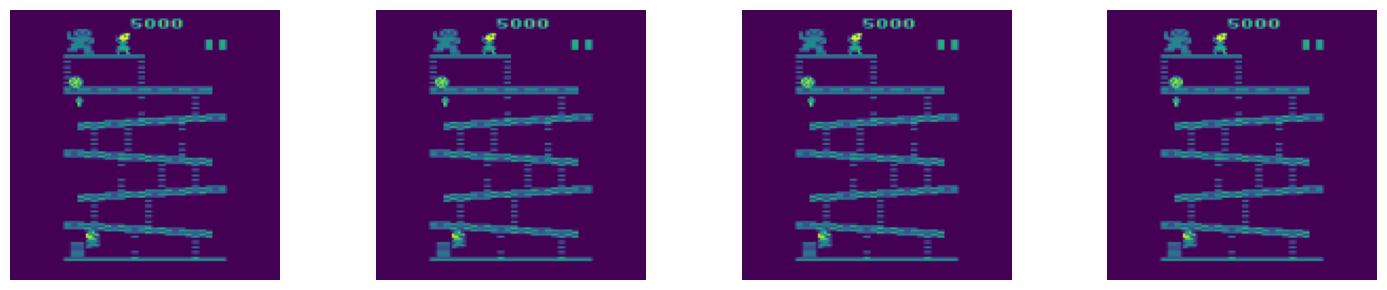

In [29]:
# plot each stack in a row
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, frame_stack, figsize=(15, 3))
for i in range(frame_stack):
    img = stack[i].transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()